1. Ожирение --- https://www.euro.who.int/__data/assets/pdf_file/0015/243321/Russian-Federation-WHO-Country-Profile.pdf

2. Диабет --- https://www.who.int/diabetes/country-profiles/rus_en.pdf

In [25]:
import pandas as pd

In [26]:
def age2interval(pd_age_series):
    return pd_age_series.apply(lambda x: pd.Interval(left=int(x[:x.find('-')]), right=int(x[x.find('-') + 1:]), closed='both'))

In [27]:
nw1000m = pd.read_csv('data/nw1000m.csv')
nw1000m['age'] = age2interval(nw1000m['age'])
nw1000m['female_proba'] = nw1000m['value'] / (nw1000m['value']  + 1000)

In [28]:
from scipy import stats

age_proba = pd.read_csv('data/age_proba.csv')
age_variable = stats.rv_discrete(name='russianage', values=(age_proba['age'], age_proba['proba']))


In [29]:
age_sex_risk = pd.read_csv('data/age_sex_risk.csv')
age_sex_risk['age'] = age2interval(age_sex_risk['age'])

In [30]:
def cad_age(age):
    return 1/30

def cad_sex(sex): # модификатор от 0 до inf
    return 1


def cad_age_sex(age, sex):
    risk_age = age_sex_risk[age_sex_risk['age'].apply(lambda x: age in x)]
    return float(risk_age[risk_age['sex'] == sex]['risk'])

def cad_smoke(smoke):
    return 1.3 if smoke == 1 else 1

def cad_overweight(sex):
    return 
        
    

In [60]:
from scipy.stats import bernoulli

smoking = pd.read_csv('data/smoking.csv')
smoking['age'] = age2interval(smoking['age'])

def smoke_proba_age_sex(age, sex):
    """
    age: возраст
    sex: 1 - муж., 0 - жен
    
    return: 1 - курит, 0 - не курит (с учетом пола и возраста)
    """
    smoking_age = smoking[smoking['age'].apply(lambda x: age in x)]
    
    smoke_proba = float(smoking_age[smoking_age['sex'] == sex]['smoke'])
    
    rv = stats.bernoulli(smoke_proba)
    return rv.rvs(), smoke_proba

class People:
    risks = dict()
    
    def gen_age(self):
        age = lambda: q if (q := age_variable.rvs()) >= 20 else age()
        self.age = age()
        
        # self.risks['age'] = cad_age(self.age)
        # self.risk = self.risks['age']
        
    
    def gen_sex(self):
        fem_prob = float(nw1000m[nw1000m['age'].apply(lambda x: self.age in x)]['female_proba'])
        rv = bernoulli(1 - fem_prob)
        self.sex = rv.rvs()
        
        # self.risks['sex'] = cad_sex(self.sex)
        
        # self.risk = self.risk*self.risks['sex']
        self.risks['age_sex'] = cad_age_sex(self.age, self.sex)
        self.risk = cad_age_sex(self.age, self.sex)
        
        
    def gen_smoke(self):

        self.smoke, _ = smoke_proba_age_sex(self.age, self.sex)
        self.risks['smoke'] = cad_smoke(self.smoke)
        
        self.risk = self.risk 
        
    def gen_overweight(self):
        overweight_proba = 0.247 if self.sex == 0 else 0.179
        rv = bernoulli(overweight_proba)
        self.overweight = rv.rvs()
        self.risk *= (2 * overweight_proba + (1 - overweight_proba)) / 2 if self.overweight == 1 else 1
    
   # def gen_diabetes(self):
        
    #    diabetes_proba = 
    #    rv = bernoulli(diabetes_proba)
    #    self.diabetes = rv.rvs()
        
     #   self.risk *= 4 if self.diabetes == 1 else 1
    
    def gen_snps(self):
        ...
        
        
    def calc_target(self):
        rv = bernoulli(self.risk)
        self.target =  rv.rvs()
        
    def to_series(self):
        return pd.Series(
                          { 'age': self.age
                          , 'sex': self.sex
                          , 'smoke': self.smoke
                          , 'overweight': self.overweight
                          # , 'diabetes': self.diabetes
                          , 'overall_risk': self.risk
                          , 'disease (target)': self.target
                          })
        
    def gen_all(self):
        self.gen_age()
        self.gen_sex()
        self.gen_smoke()
        self.gen_overweight()
        # self.gen_diabetes()
        self.gen_snps()
        self.calc_target()
        
        

In [61]:
def make_sample(number):
    peoples = []
    for _ in range(number):
        p = People()
        p.gen_all()
        peoples.append(p.to_series())
    return pd.DataFrame(peoples)

In [69]:
%%time
df = make_sample(5000)

CPU times: user 36.6 s, sys: 36 ms, total: 36.7 s
Wall time: 36.7 s


In [70]:
df['disease (target)'].sum()

282.0

<AxesSubplot:xlabel='overall_risk', ylabel='Density'>

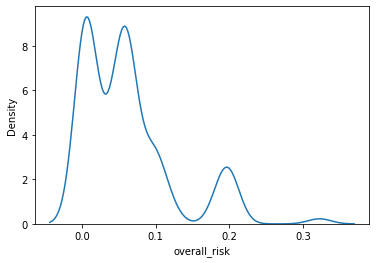

In [63]:
import seaborn as sns

sns.kdeplot(df['overall_risk'])

<AxesSubplot:xlabel='overall_risk', ylabel='Density'>

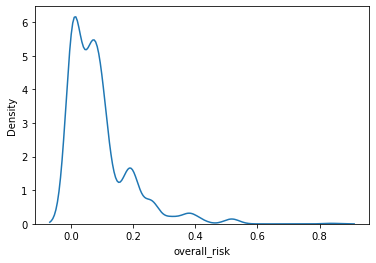

In [56]:
import seaborn as sns

sns.kdeplot(df['overall_risk'])

In [18]:
df['disease (target)'].sum()

84.0